In [1]:
import numpy as np
import pandas as pd
import math
from gaugefixer import GaugeFixer, Encoder 

In [2]:
def predict_num_params(e: Encoder):
    """
    Predict number of parameters M for different model types based on encoder properties.
    
    Args:
        e: Encoder object with attributes L (sequence length), alpha (alphabet size), 
           K (interaction order), and model_type
           
    Returns:
        int: Predicted number of parameters M
    """
    match e.model_type.lower():
        case 'additive':
            return 1 + e.alpha * e.L
            
        case 'neighbor':
            return 1 + e.alpha * e.L + (e.alpha**2) * (e.L-1)
            
        case 'pairwise':
            return 1 + e.alpha * e.L + math.comb(e.L, 2) * (e.alpha**2)
            
        case 'allorder':
            return (e.alpha + 1)**e.L
            
        case 'korder':
            return sum(math.comb(e.L, k) * (e.alpha**k) for k in range(e.K + 1))
            
        case 'kadjacent':
            return (e.alpha + 1)**e.K + sum((e.L - e.K) * math.comb(e.K-1, k-1) * (e.alpha**k) for k in range(1, e.K + 1))
            #return 1 + sum((e.L - k + 1) * (e.alpha**k) for k in range(1, e.K + 1))

        case _:
            raise ValueError(f"Unknown model type: {e.model_type}")


In [3]:
def predict_fast_mult_ops(e: Encoder):
    """
    Predict number of multiplication operations for the fast algorithm based on encoder properties.
    
    Args:
        e: Encoder object with attributes L (sequence length), alpha (alphabet size), 
           K (interaction order), and model_type
           
    Returns:
        int: Predicted number of multiplication operations
    """
    # Get number of parameters M
    M = predict_num_params(e)
    
    match e.model_type.lower():
        case 'additive':
            return (e.alpha + 1) * M
            
        case 'neighbor':
            return 2 * (e.L - 1) * (e.alpha + 1) * M
            
        case 'pairwise':
            return 2 * math.comb(e.L, 2) * (e.alpha + 1) * M
            
        case 'allorder':
            return e.L * (e.alpha + 1) * M
            
        case 'korder':
            return e.K * math.comb(e.L, e.K) * (e.alpha + 1) * M
            
        case 'kadjacent':
            return e.K * (e.L - e.K + 1) * (e.alpha + 1) * M
            
        case _:
            raise ValueError(f"Unknown model type: {e.model_type}")


In [4]:
encoder_specs = []
kwargs = {'alphabet_name':'dna', 'L':1}
encoder_specs += [
    dict(model_type='additive', **kwargs),
]
for L in [2, 8]:
    kwargs = {'alphabet_name':'dna', 'L':L}
    encoder_specs += [
        dict(model_type='additive', **kwargs),
        dict(model_type='neighbor', **kwargs),
        dict(model_type='pairwise', **kwargs),
        dict(model_type='allorder', **kwargs),
    ]
    for K in [1, 5, L]:
        if K <= L:
            encoder_specs += [
                dict(model_type='Korder', K=K, **kwargs),
                dict(model_type='Kadjacent', K=K, **kwargs)
            ]

# Create headers
print(f"{'Model Type':<12} {'L':>4} {'α':>4} {'K':>4} {'Predicted':>12} {'Actual':>12} {'Match':>8}")
print("-" * 62)

# Print each row
for spec in encoder_specs:
    e = Encoder(**spec)
    predicted = predict_num_params(e)
    actual = e.n_features
    k_val = spec.get('K', '-')  # Get K if exists, else '-'
    print(f"{spec['model_type']:<12} {e.L:>4} {e.alpha:>4} {k_val:>4} {predicted:>12} {actual:>12} {'True' if predicted == actual else 'False':>8}")



Model Type      L    α    K    Predicted       Actual    Match
--------------------------------------------------------------
additive        1    4    -            5            5     True
additive        2    4    -            9            9     True
neighbor        2    4    -           25           25     True
pairwise        2    4    -           25           25     True
allorder        2    4    -           25           25     True
Korder          2    4    1            9            9     True
Kadjacent       2    4    1            9            9     True
Korder          2    4    2           25           25     True
Kadjacent       2    4    2           25           25     True
additive        8    4    -           33           33     True
neighbor        8    4    -          145          145     True
pairwise        8    4    -          481          481     True
allorder        8    4    -       390625       390625     True
Korder          8    4    1           33           33  

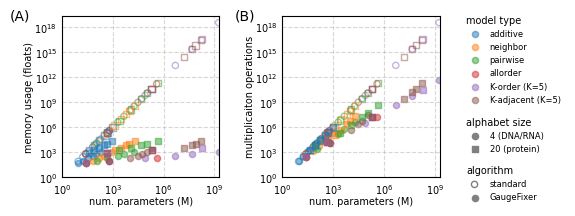

In [5]:
from matplotlib.patches import bbox_artist
import matplotlib.pyplot as plt
import numpy as np

figsize=(6.5,2.10)

xmax = 2E9

def get_model_params(L, alpha, K=None):
    """Calculate number of parameters for each model type"""
    params = {
        'additive': 1 + alpha * L,
        'neighbor': 1 + alpha * L + alpha**2 * (L-1),
        'pairwise': 1 + alpha * L + (L * (L-1)/2) * alpha**2,
        'allorder': (alpha + 1)**L
    }
    if K is not None:
        params.update({
            'korder': sum(math.comb(L,k) * alpha**k for k in range(K+1)),
            'kadjacent': (alpha + 1)**K + (L-K)*sum(math.comb(K-1,k-1) * alpha**k for k in range(1,K+1))
        })
    # Filter out models with too many parameters
    return {k:v for k,v in params.items() if v <= xmax}

def get_memory_ops(M, L, alpha):
    """Calculate memory and operations for naive and fast approaches"""
    return {
        'naive_mem': M**2,
        'fast_mem': L * (alpha+1)**2,
        'naive_ops': M**2,
        'fast_ops': L * (alpha+1) * M  # Using all-order as example
    }

plt.rcParams.update({'font.size': 7.0})
plt.rcParams.update({'legend.fontsize': 6.0})


# Create figure with two panels side by side, leaving space for legends on right
fig = plt.figure(figsize=figsize)
# Create gridspec with 3 columns: plot1, plot2, legend space
gs = fig.add_gridspec(1, 3, width_ratios=[1, 1, .4], wspace=0.5)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[0, 2])  # Legend space
ax3.axis('off')  # Turn off axes elements

# Define colors for each model type
model_colors = {
    'additive': 'C0',
    'neighbor': 'C1', 
    'pairwise': 'C2',
    'allorder': 'C3',
    'korder': 'C4',
    'kadjacent': 'C5'
}

# Generate points for smooth curves
L_range = [2, 4, 8, 16, 24, 48]
alphas = [4, 20]  # DNA and protein alphabets
K = 5  # Example K value for K-order models
markers = {4: 'o', 20: 's'}  # circle for DNA, square for protein
alpha_opacity = {4: 0.5, 20: 0.5}

# Create lines for legends
model_lines = []
alpha_lines = []
method_lines = []

for alpha in alphas:
    for model_type in model_colors.keys():
        M_values = []
        naive_mem = []
        fast_mem = []
        naive_ops = []
        fast_ops = []
        
        for L in L_range:
            params = get_model_params(L, alpha, K=K)
            if model_type in params:
                M = params[model_type]
                metrics = get_memory_ops(M, L, alpha)
                
                M_values.append(M)
                naive_mem.append(metrics['naive_mem'])
                fast_mem.append(metrics['fast_mem'])
                naive_ops.append(metrics['naive_ops'])
                fast_ops.append(metrics['fast_ops'])
        
        if M_values:  # Only plot if we have valid points
            # Plot memory (fast first, then naive)
            scatter1 = ax1.scatter(M_values, fast_mem, color=model_colors[model_type], 
                    marker=markers[alpha], alpha=alpha_opacity[alpha], s=20)
            scatter2 = ax1.scatter(M_values, naive_mem, color=model_colors[model_type], 
                    marker=markers[alpha], facecolors='none', alpha=alpha_opacity[alpha], s=20)
            
            # Plot operations (fast first, then naive)
            ax2.scatter(M_values, fast_ops, color=model_colors[model_type], 
                    marker=markers[alpha], alpha=alpha_opacity[alpha], s=20)
            ax2.scatter(M_values, naive_ops, color=model_colors[model_type], 
                    marker=markers[alpha], facecolors='none', alpha=alpha_opacity[alpha], s=20)
            
            # Store points for legend only once (using solid dots)
            if alpha == 4:
                model_lines.append((scatter1, model_type))

legend_left_loc = -0.7

# Create separate legend for models in ax3
first_legend = ax3.legend([scatter for scatter, _ in model_lines],
                         [name if not name[0]=='k' else f'K-{name[1:]} (K={K})' for _, name in model_lines ],
                         title='model type',
                         bbox_to_anchor=(legend_left_loc, 1.05), 
                         loc='upper left',
                         alignment='left', framealpha=1.0, edgecolor='none')

# Add legend for alpha values
alpha_legend = ax3.legend([plt.scatter([0], [0], color='gray', marker='o', s=20),
                          plt.scatter([0], [0], color='gray', marker='s', s=20)],
                         ['4 (DNA/RNA)', '20 (protein)'],
                         title='alphabet size',
                         bbox_to_anchor=(legend_left_loc, 0.42),
                         loc='upper left',
                         alignment='left', framealpha=1.0, edgecolor='none')

# Add legend for naive vs fast (fast first)
method_legend = ax3.legend([plt.scatter([0], [0], color='gray', marker='o', facecolors='none', s=20),
                            plt.scatter([0], [0], color='gray', marker='o', s=20)],
                          ['standard', 'GaugeFixer'],
                          title='algorithm',
                          bbox_to_anchor=(legend_left_loc, 0.12),
                          loc='upper left',
                          alignment='left', framealpha=1.0, edgecolor='none')



# Add all legends to ax3
ax3.add_artist(first_legend)
ax3.add_artist(method_legend)
ax3.add_artist(alpha_legend)

# Customize plots
xticks = [10**0, 10**3, 10**6, 10**9]
for ax in [ax1, ax2]:
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.grid(True, which='both', linestyle='--', alpha=0.5)
    ax.set_xlim(1, xmax)
    ax.set_ylim(bottom=1)
    ax.tick_params(length=0)  # Set tick length to 0
    ax.set_xticks(xticks)
ax1.set_xlabel('num. parameters (M)', labelpad=0)
ax1.set_ylabel('memory usage (floats)', labelpad=0)

ax2.set_xlabel('num. parameters (M)', labelpad=0)
ax2.set_ylabel('multiplicaiton operations', labelpad=0)


fig.text(s='(A)', x=0.045, y=0.91, va='top', ha='left', size=10)
fig.text(s='(B)', x=0.39, y=0.91, va='top', ha='left', size=10)


# Adjust layout to ensure legends are visible
fig.savefig('fig1_resources.pdf', bbox_inches='tight')
plt.show()
